# Change in proportion of touch neurons and tuned neurons
### Refactoring from 230108_combine_neuronal_activity_with_dataset.ipynb
### Questions
- Does proportion of touch neurons change across training?
- Does proportion of tuned neurons (among touch neurons) change across training?

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import os, glob, h5py
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import notebook
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl

h5_dir_1 = Path('H:/')
h5_dir_2 = Path('F:/')
b_dir = Path('D:/SoloData/')
w_dir = Path('D:/WhiskerVideo/')
mice =          [25,    27,   30,   36,     37,     38,     39,     41,     52,     53,     54,     56]
expert_mice = [25, 27, 30, 36, 39, 52]
ref_sessions = [4,3,3,1,1,3]
exp_sessions = [19,10,21,17,23,21]
# refSessions =   [4,     3,    3,    1,      7,      2,      1,      3,      3,      3,      3,      3]
# expSessions =   [19,    10,   21,   17,     0,      0,      23,     0,      21,     0,      0,      0]
# zoom =          [2,     2,    2,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7,    1.7]
image_rate_list = [30.8359, 30.8359, 30.8359, 30.8359, 
                    24.2892, 24.2892, 24.2892, 24.2892,
                    30.8359, 30.8359, 30.8359, 30.8359] # from .mat file (sbx)
image_size_list = [[512,796], [512,796], [512,796], [512,796], 
                    [650,796], [650,796], [650,796], [650,796], 
                    [512,796], [512,796], [512,796], [512,796]] # from .mat file (sbx)
planes = range(1,9)

save_dir = Path('C:\JK')
# save_dir = Path('/Users/jinho.kim/Dropbox/Works/Projects/2020 Neural stretching in S1/Data')

In [ ]:
# Function calculating correct rate
def calculate_correct_rate(wb_df):
    temp_df = wb_df.drop_duplicates('trialNum')[['trialNum','correct','wrong','miss']]
    num_trials = len(temp_df)
    num_correct = temp_df.correct.sum()
    num_wrong = temp_df.wrong.sum()
    num_miss = temp_df.miss.sum()
    num_answer = num_correct + num_wrong
    assert num_correct + num_wrong + num_miss == num_trials
    answer_rate = 1 - num_miss / num_trials
    correct_rate = num_correct / num_trials
    return correct_rate, num_answer, answer_rate

In [ ]:
# Making crude tourh response dataframes
# Save f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl' files

trial_start_buffer_frame = 3 # to prevent abrupt increase of signal by laser on after ITI and possible contamination by trial start cue

for emi in range(3):
    for plane in range(1,9):

        mouse = expert_mice[emi]
        if emi < 3:
            h5_dir = h5_dir_1
        else:
            h5_dir = h5_dir_2

        plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
        sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
        session_nums = sts_reg['selected_session_num']

        tr_sessions = [] # touch response sessions
        tr_num_roi = []
        tr_correct_rate = []
        tr_num_answer = []
        tr_num_touch_trials = []
        tr_pre_pole_len = []
        tr_angle = []
        tr_correct = []
        tr_num_pre_answer_touch = []
        tr_num_post_answer_touch = []

        tr_p_pre_answer = []
        tr_p_post_answer = []
        tr_p_post_pre = []
        tr_effect_pre_answer = []
        tr_effect_post_answer = []
        tr_effect_post_pre = []

        tr_pre_pole_activity = []
        tr_pre_answer_response = []
        tr_post_answer_response = []
        tr_post_pole_activity = []

        # Load iscell, which is same for all the sessions in a plane
        session_num = session_nums[0]
        session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
        iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
        iscell_ind = np.where(iscell)[0]
        num_cell = len(iscell_ind)
        for session_num in session_nums:
            session_plane_info = f'JK{mouse:03d} S{session_num:02d} plane{plane}'
            print(f'Processing {session_plane_info}')
            
            # Load events and z-score them
            session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
            events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
            events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
            assert events.shape[1] == len(iscell)
            events_zscore = events_zscore[:,iscell_ind]

            # Load whisker-behavior dataFrame
            wb_pkl_fn = f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl'
            if os.path.isfile(plane_dir / wb_pkl_fn):
                wb_df = pd.read_pickle(plane_dir / wb_pkl_fn)
                if wb_df.task_target.values[-1] == 'Angle': # 2-angle training sessions only
                    if np.nansum(wb_df.touch_count.values) > 0: # removing whisker-less sessions
                        correct_rate, num_answer, answer_rate = calculate_correct_rate(wb_df)
                        
                        trial_nums = wb_df.trialNum.unique()
                        pre_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
                        pre_pole_activity[:] = np.nan
                        pre_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
                        pre_answer_response[:] = np.nan
                        post_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
                        post_answer_response[:] = np.nan
                        post_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
                        post_pole_activity[:] = np.nan
                        pre_pole_length = np.empty(len(trial_nums),)
                        pre_pole_length[:] = np.nan
                        angle = np.empty(len(trial_nums),)
                        angle[:] = np.nan
                        correct = np.empty(len(trial_nums),)
                        correct[:] = np.nan
                        num_pre_answer_touch = np.empty(len(trial_nums),)
                        num_pre_answer_touch[:] = np.nan
                        num_post_answer_touch = np.empty(len(trial_nums),)
                        num_post_answer_touch[:] = np.nan
                        num_touch_trial = 0
                        for ti, trial_num in enumerate(trial_nums):
                            trial_wb_df = wb_df[wb_df.trialNum == trial_num]
                            if (not trial_wb_df.iloc[0].miss) and (np.nansum(trial_wb_df.touch_count.values) > 0): # only when there was an answer and at least one touch
                                num_touch_trial += 1

                                angle[ti] = trial_wb_df.iloc[0].pole_angle
                                correct[ti] = trial_wb_df.iloc[0].correct
                                
                                trial_events_zscore = events_zscore[np.where(wb_df.trialNum == trial_num)[0],:]
                                if len(np.where(trial_wb_df.pole_moving_frame.values)[0]) > 0:
                                    first_pole_moving_ind = min(np.where(trial_wb_df.pole_up_frame.values)[0][0], np.where(trial_wb_df.pole_moving_frame.values)[0][0])
                                else:
                                    first_pole_moving_ind = np.where(trial_wb_df.pole_up_frame.values)[0][0]
                                pre_pole_inds = range(trial_start_buffer_frame,first_pole_moving_ind)
                                pre_pole_length[ti] = len(pre_pole_inds)
                                pre_answer_pole_inds = range(np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][0], np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][-1] +2)
                                pre_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[pre_answer_pole_inds])

                                post_answer_pole_inds = np.where(trial_wb_df.post_answer_pole_up_frame.values)[0] # last frame should be included
                                post_pole_inds = []
                                
                                if len(post_answer_pole_inds) > 0:
                                    assert post_answer_pole_inds[0] - pre_answer_pole_inds[-1] == 1
                                    post_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[post_answer_pole_inds])
                                    if len(trial_wb_df) > post_answer_pole_inds[-1]:
                                        post_pole_inds = range(post_answer_pole_inds[-1]+1, len(trial_wb_df))
                                else:
                                    post_answer_num_touch = 0
                                
                                num_pre_answer_touch[ti] = pre_answer_num_touch
                                num_post_answer_touch[ti] = post_answer_num_touch

                                assert len(np.intersect1d(pre_pole_inds, pre_answer_pole_inds))==0
                                assert len(np.intersect1d(pre_answer_pole_inds, post_answer_pole_inds))==0
                                
                                pre_pole_activity[ti,:] = np.mean(trial_events_zscore[pre_pole_inds, :], axis=0)
                                if pre_answer_num_touch > 0:
                                    pre_answer_response[ti,:] = np.mean(trial_events_zscore[pre_answer_pole_inds,:], axis=0) / pre_answer_num_touch
                                if post_answer_num_touch > 0:
                                    post_answer_response[ti,:] = np.mean(trial_events_zscore[post_answer_pole_inds,:], axis=0) / post_answer_num_touch
                                if len(post_pole_inds) > 0:
                                    post_pole_activity[ti,:] = np.mean(trial_events_zscore[post_pole_inds, :], axis=0)
                        
                        pvalue_pre_answer_response = stats.ttest_1samp(pre_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
                        pvalue_post_answer_response = stats.ttest_1samp(post_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
                        pvalue_post_pre_answer = stats.ttest_1samp(post_answer_response - pre_answer_response, 0, nan_policy='omit')[1].data
                        effect_pre_answer_response = np.nanmean(pre_answer_response - pre_pole_activity, axis=0)
                        effect_post_answer_response = np.nanmean(post_answer_response - pre_pole_activity, axis=0)
                        effect_post_pre_answer = np.nanmean(post_answer_response - pre_answer_response, axis=0)

                        # Collect the results
                        tr_sessions.append(session_num)
                        tr_num_roi.append(num_cell)
                        tr_correct_rate.append(correct_rate)
                        tr_num_answer.append(num_answer)
                        tr_num_touch_trials.append(num_touch_trial)
                        tr_pre_pole_len.append(pre_pole_length)
                        tr_angle.append(angle)
                        tr_correct.append(correct)
                        tr_num_pre_answer_touch.append(num_pre_answer_touch)
                        tr_num_post_answer_touch.append(num_post_answer_touch)

                        tr_p_pre_answer.append(pvalue_pre_answer_response)
                        tr_p_post_answer.append(pvalue_post_answer_response)
                        tr_p_post_pre.append(pvalue_post_pre_answer)
                        tr_effect_pre_answer.append(effect_pre_answer_response)
                        tr_effect_post_answer.append(effect_post_answer_response)
                        tr_effect_post_pre.append(effect_post_pre_answer)

                        tr_pre_pole_activity.append(pre_pole_activity)
                        tr_pre_answer_response.append(pre_answer_response)
                        tr_post_answer_response.append(post_answer_response)
                        tr_post_pole_activity.append(post_pole_activity)

        # Save results in pkl file as DataFrame
        tr_crude = pd.DataFrame({'session': tr_sessions,
                                'num_roi': tr_num_roi,
                                'correct_rate': tr_correct_rate,
                                'num_answer': tr_num_answer,
                                'num_touch_trials': tr_num_touch_trials,
                                'pre_pole_len': tr_pre_pole_len,
                                'angle': tr_angle,
                                'correct': tr_correct,
                                'num_touch_pre_answer': tr_num_pre_answer_touch,
                                'num_touch_post_answer': tr_num_post_answer_touch,
                                'p_pre_answer': tr_p_pre_answer,
                                'p_post_answer': tr_p_post_answer,
                                'effect_size_pre_answer': tr_effect_pre_answer,
                                'effect_size_post_answer': tr_effect_post_answer,
                                'effect_size_post_pre': tr_effect_post_pre,
                                'pre_pole_activity': tr_pre_pole_activity,
                                'pre_answer_response': tr_pre_answer_response,
                                'post_answer_response': tr_post_answer_response,
                                'post_pole_activity': tr_post_pole_activity,
                                })
        save_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
        tr_crude.to_pickle(save_dir / save_fn)
# Took 5 min for 3 mice

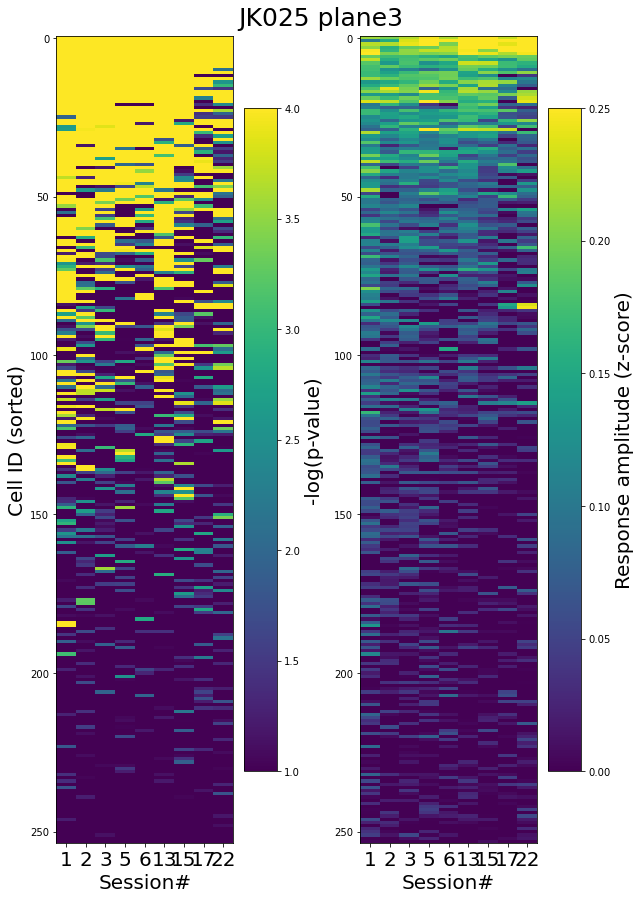

In [12]:
# pre-answer touch response effect size
# Sorted by either p-value of first session or by the mean p-value of all sessions, per plane
sorting_list = ['first-session-p-value', 'mean-session-p-value']
sorting_i = 1 # 0 or 1

mi = 0
mouse = expert_mice[mi]
plane = 3

load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
tr_crude = pd.read_pickle(save_dir / load_fn)

num_roi = tr_crude.num_roi.values[0]
session_nums = tr_crude.session.values
p_pre_answer = []
for ppa in tr_crude.p_pre_answer.values:
    if len(p_pre_answer) == 0:
        p_pre_answer = -np.log10(ppa)
    else:
        p_pre_answer = np.vstack((p_pre_answer, -np.log10(ppa)))
p_pre_answer = p_pre_answer.transpose()
if sorting_list[sorting_i] == 'first-session-p-value':
    sort_i = np.argsort(-p_pre_answer[:,0])
elif sorting_list[sorting_i] == 'mean-session-p-value':
    sort_i = np.argsort(-np.nanmean(p_pre_answer, axis=1))
else:
    raise ValueError('sorting_list[sorting_i] is not valid')
sort_p_pre_answer = p_pre_answer[sort_i,:]

effect_pre_answer = []
for epa in tr_crude.effect_size_pre_answer.values:
    if len(effect_pre_answer) == 0:
        effect_pre_answer = epa
    else:
        effect_pre_answer = np.vstack((effect_pre_answer, epa))
effect_pre_answer = effect_pre_answer.transpose()
sort_e_pre_answer = effect_pre_answer[sort_i, :]

fig, ax = plt.subplots(1,2,figsize=(effect_pre_answer.shape[1],effect_pre_answer.shape[0]/20))
p_matrix = ax[0].imshow(sort_p_pre_answer, vmin=1, vmax=4, aspect='auto')
ax[0].set_xticks(range(len(session_nums)))
ax[0].set_xticklabels(session_nums, fontsize=20)
ax[0].set_xlabel('Session#', fontsize=20)
ax[0].set_ylabel('Cell ID (sorted)', fontsize=20)
cb = fig.colorbar(p_matrix, ax=ax[0]).set_label(label='-log(p-value)', size=20)
# cb.ax.tick_params(labelsize=15)
e_matrix = ax[1].imshow(sort_e_pre_answer, vmin=0, vmax=0.25, aspect='auto')
ax[1].set_xticks(range(len(session_nums)))
ax[1].set_xticklabels(session_nums, fontsize=20)
ax[1].set_xlabel('Session#', fontsize=20)
cb = fig.colorbar(e_matrix, ax=ax[1]).set_label(label='Response amplitude (z-score)', size=20)
fig.suptitle(f'JK{mouse:03d} plane{plane}', fontsize=25)
fig.tight_layout()

In [10]:
def touch_response_prop_plot(tr_crude, target_logp_value=2, target_response=None):
    cmap = mpl.cm.get_cmap('turbo')
    task_performance = tr_crude.correct_rate.values
    num_roi = tr_crude.num_roi.values[0]
    session_nums = tr_crude.session.values
    num_sessions = len(session_nums)
    p_pre_answer = []
    for ppa in tr_crude.p_pre_answer.values:
        if len(p_pre_answer) == 0:
            p_pre_answer = -np.log10(ppa)
        else:
            p_pre_answer = np.vstack((p_pre_answer, -np.log10(ppa)))
    p_bins = [*np.round(np.arange(0,10.1,0.1),2), 10**3]
    p_pre_answer_cumdist = []
    for i in range(num_sessions):
        cumdist = np.cumsum(np.histogram(p_pre_answer[i,:], bins=p_bins)[0]/num_roi)
        if len(p_pre_answer_cumdist) == 0:
            p_pre_answer_cumdist = cumdist.copy()
        else:
            p_pre_answer_cumdist = np.vstack((p_pre_answer_cumdist, cumdist))

    effect_pre_answer = []
    for epa in tr_crude.effect_size_pre_answer.values:
        if len(effect_pre_answer) == 0:
            effect_pre_answer = epa.copy()
        else:
            effect_pre_answer = np.vstack((effect_pre_answer, epa))
    min_effect = np.percentile(effect_pre_answer[:],0.5)
    max_effect = np.amax(effect_pre_answer)
    e_bins = [*np.round(np.arange(min_effect,max_effect+0.01,0.01),2)]
    e_pre_answer_cumdist = []
    for i in range(num_sessions):
        cumdist = np.cumsum(np.histogram(effect_pre_answer[i,:], bins=e_bins)[0]/num_roi)
        if len(e_pre_answer_cumdist) == 0:
            e_pre_answer_cumdist = cumdist.copy()
        else:
            e_pre_answer_cumdist = np.vstack((e_pre_answer_cumdist, cumdist))

    fig, ax = plt.subplots(2,2,figsize=(12,10))
    for i in range(num_sessions):
        color_val = 1-i/(num_sessions-1)
        # ax[0].plot(p_bins[:-1], p_pre_answer_cumdist[i], color= np.array([1,1,1]) - np.array([*cmap(color_val)])[:-1], label=f'{session_nums[i]}')
        ax[0,0].plot(p_bins[:-1], p_pre_answer_cumdist[i], color= cmap(color_val), label=f'{session_nums[i]}')
    ax[0,0].legend()
    ax[0,0].set_xlabel('-Log(p-value)')
    ax[0,0].set_ylabel('Cumulative distribution')
    ax[0,0].set_title('p-value')
    ax[0,0].axvline(2, color=[0.5, 0.5, 0.5], linestyle='--')

    for i in range(num_sessions):
        color_val = 1-i/(num_sessions-1)
        ax[0,1].plot(e_bins[:-1], e_pre_answer_cumdist[i], color= cmap(color_val), label=f'{session_nums[i]}')
    
    ax[0,1].legend()
    ax[0,1].set_xlabel('Response amplitude (z-score)')
    ax[0,1].set_ylabel('Cumulative distribution')
    ax[0,1].set_title('Response amplitude')

    fig.suptitle(f'JK{mouse:03d} plane{plane}')

    ax[1,0].scatter(1-p_pre_answer_cumdist[:,np.argmin(np.abs(np.array(p_bins)-target_logp_value))], task_performance, c = 1-np.array(range(num_sessions))/(num_sessions-1), cmap=cmap)
    ax[1,0].set_ylabel('Performance')
    ax[1,0].set_xlabel(f'Prop neurons response p < {10**(-target_logp_value):.4f}')

    if target_response is None:
        e_ind = np.argmin(np.abs(np.mean(e_pre_answer_cumdist,axis=0)-0.8))
        target_response = e_bins[e_ind]
    else:
        e_ind = np.argmin(np.abs(np.array(e_bins)-target_response))
    ax[1,1].scatter(1-e_pre_answer_cumdist[:,e_ind], task_performance, c = 1-np.array(range(num_sessions))/(num_sessions-1), cmap=cmap)
    ax[1,1].set_ylabel('Performance')
    ax[1,1].set_xlabel(f'Prop neurons response amplitude > {target_response}')

    ax[0,1].axvline(target_response, color=[0.5,0.5,0.5], linestyle='--')


    fig.tight_layout()

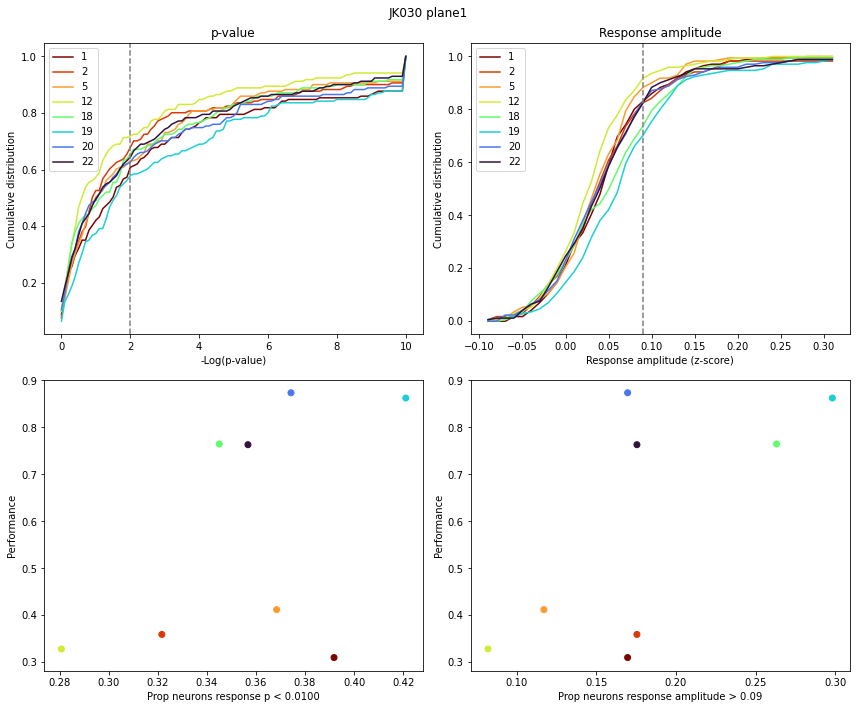

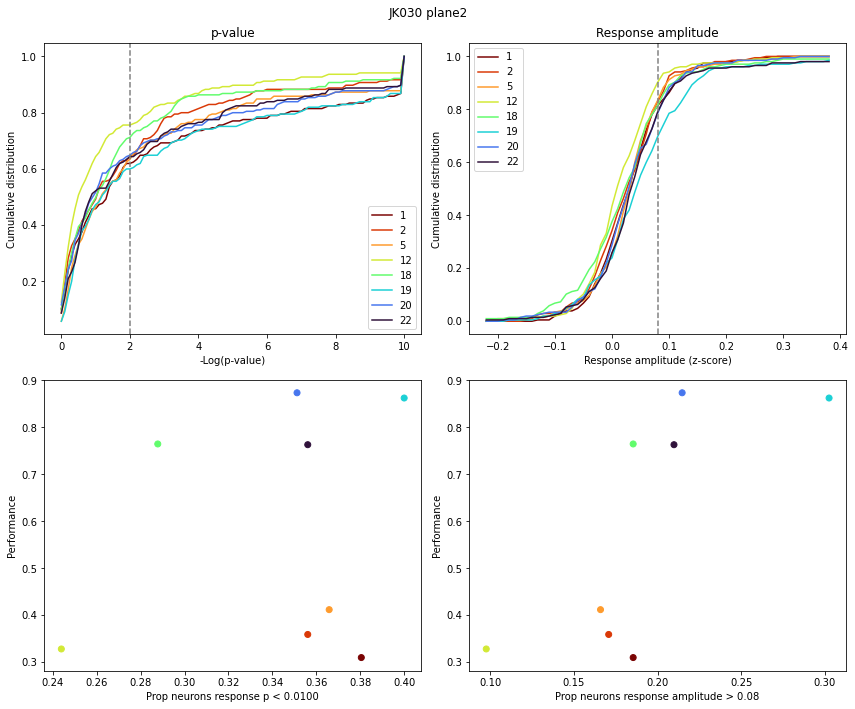

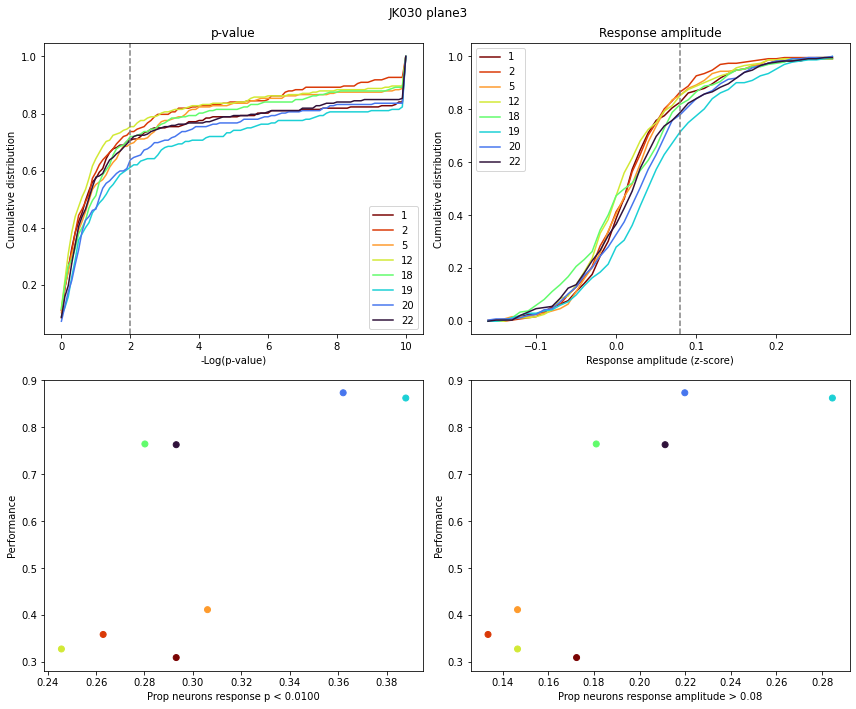

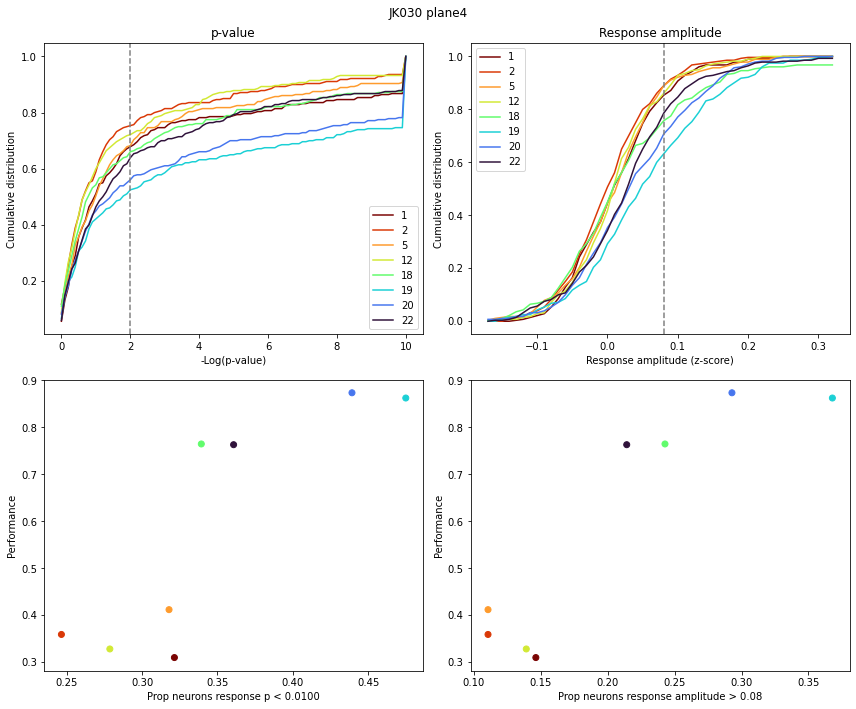

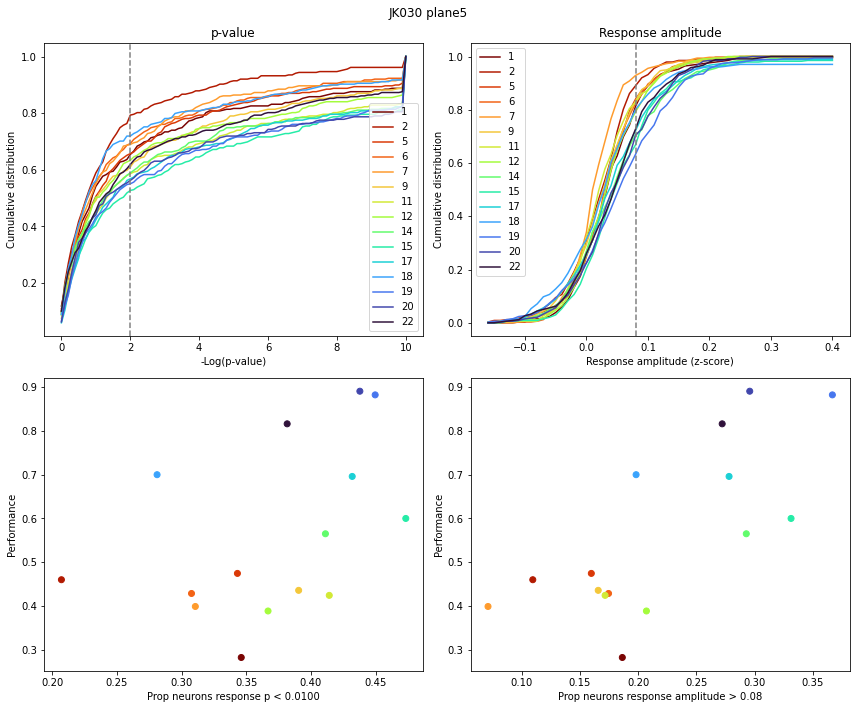

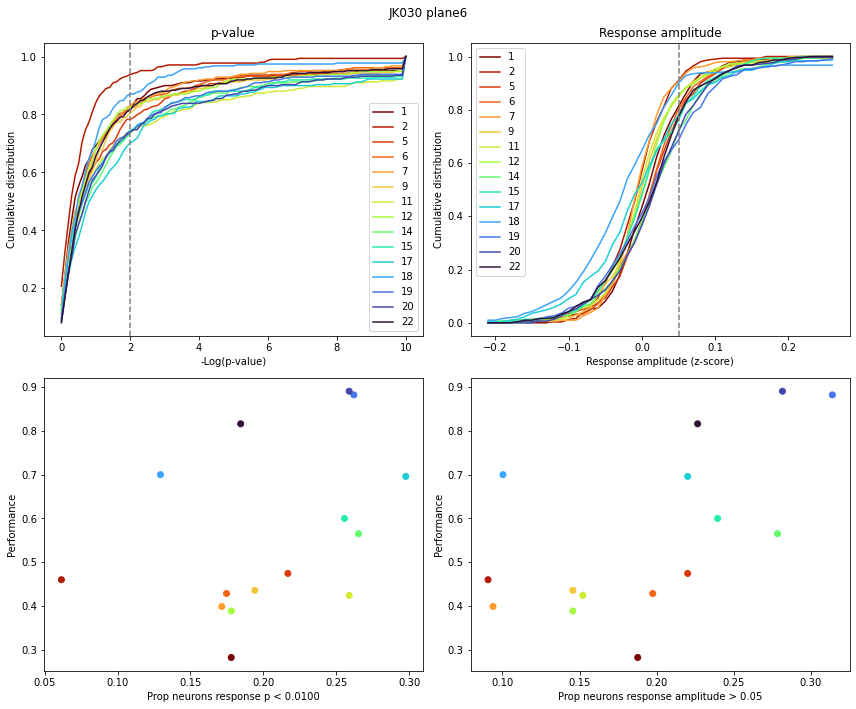

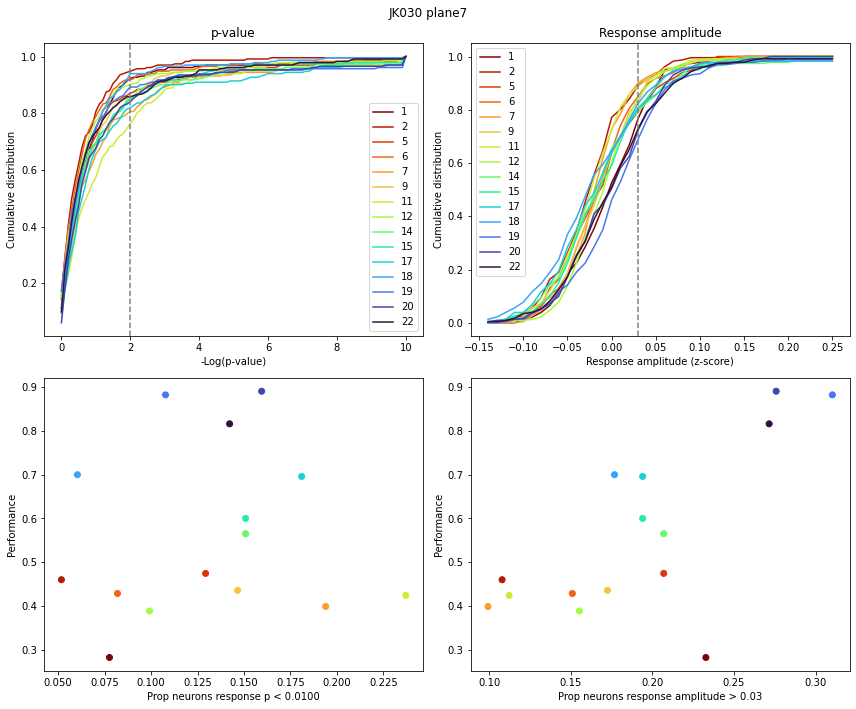

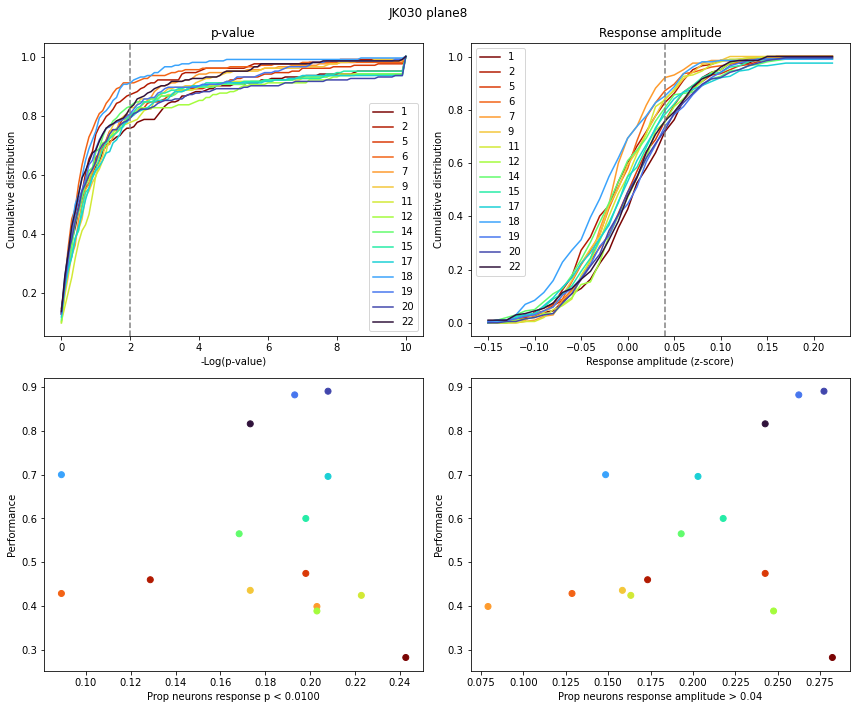

In [11]:

mouse = 30
for plane in range(1,9):
    load_fn = f'JK{mouse:03d}_plane{plane}_touch_response_crude.pkl'
    tr_crude = pd.read_pickle(save_dir / load_fn)
    touch_response_prop_plot(tr_crude)



# For QCing individual neuron's touch responsiveness
- p-value < 0.01 (-log(p)>2) seems reasonable choice (based on the proportion)

In [ ]:
# Touch response calculation QC
# Per plane in a session


# Per trial touch response
# Pre-answer (including the answer lick frame) and post-answer (starting AFTER the answer lick frame)
# Response amplitue (in terms of z-score)
# Divided by the total # of touches within the window
# Responsiveness, tested by t-test to the values before pole up (up until the first pole moving or pole up frame, whichever is faster)
emi = 2
plane = 1

mouse = expert_mice[emi]
if emi < 3:
    h5_dir = h5_dir_1
else:
    h5_dir = h5_dir_2

plane_dir = h5_dir / f'{mouse:03d}' / f'plane_{plane}'
sts_reg = np.load(plane_dir / f'JK{mouse:03d}_plane{plane}_session_to_session_registration.npy', allow_pickle=True).item()
session_nums = sts_reg['selected_session_num']

si = 9
session_num = session_nums[si]
session_plane_info = f'JK{mouse:03d} S{session_num:02d} plane{plane}'

# Load events
session_roi_dir = plane_dir / f'{session_num:03d}' / 'plane0' / 'filtered_master_map'
iscell = np.load(session_roi_dir / 'iscell.npy', allow_pickle=True)[:,0] # Same for all sessions in a plane
events = np.load(session_roi_dir / 'spks.npy', allow_pickle=True).transpose() # To make each cell in each column, and column-direction matches with whisker-behavior dataFrame.
events_zscore = (events - np.mean(events, axis=0)) / np.std(events, axis=0)
print(f'Session {session_num:02d}')
print(events.shape)
print(len(np.where(iscell==1)[0]))
events.shape[1] == len(iscell)


events = events[:,np.where(iscell)[0]]
events_zscore = events_zscore[:,np.where(iscell)[0]]

# load whisker-behavior dataFrame
wb_df = pd.read_pickle(plane_dir / f'JK{mouse:03d}_S{session_num:02d}_plane{plane}_frame_whisker_behavior.pkl')

trial_start_buffer_frame = 3 # to prevent abrupt increase of signal by laser on after ITI and possible contamination by trial start cue
trial_nums = wb_df.trialNum.unique()
pre_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
pre_pole_activity[:] = np.nan
pre_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
pre_answer_response[:] = np.nan
post_answer_response = np.empty((len(trial_nums), events_zscore.shape[1]))
post_answer_response[:] = np.nan
post_pole_activity = np.empty((len(trial_nums), events_zscore.shape[1]))
post_pole_activity[:] = np.nan
pre_pole_length = np.zeros(len(trial_nums))

for ti, trial_num in enumerate(trial_nums):
    trial_wb_df = wb_df[wb_df.trialNum == trial_num]
    if (not trial_wb_df.iloc[0].miss) and (np.nansum(trial_wb_df.touch_count.values) > 0): # only when there was an answer and at least one touch
        trial_events_zscore = events_zscore[np.where(wb_df.trialNum == trial_num)[0],:]
        if len(np.where(trial_wb_df.pole_moving_frame.values)[0]) > 0:
            first_pole_moving_ind = min(np.where(trial_wb_df.pole_up_frame.values)[0][0], np.where(trial_wb_df.pole_moving_frame.values)[0][0])
        else:
            first_pole_moving_ind = np.where(trial_wb_df.pole_up_frame.values)[0][0]
        pre_pole_inds = range(trial_start_buffer_frame,first_pole_moving_ind)
        pre_pole_length[ti] = len(pre_pole_inds)
        pre_answer_pole_inds = range(np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][0], np.where(trial_wb_df.pre_answer_pole_up_frame.values)[0][-1] +2)
        pre_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[pre_answer_pole_inds])

        post_answer_pole_inds = np.where(trial_wb_df.post_answer_pole_up_frame.values)[0] # last frame should be included
        post_pole_inds = []
        if len(post_answer_pole_inds) > 0:
            assert post_answer_pole_inds[0] - pre_answer_pole_inds[-1] == 1
            post_answer_num_touch = np.nansum(trial_wb_df.touch_count.values[post_answer_pole_inds])
            if len(trial_wb_df) > post_answer_pole_inds[-1]:
                post_pole_inds = range(post_answer_pole_inds[-1]+1, len(trial_wb_df))
        else:
            post_answer_num_touch = 0
        
        assert len(np.intersect1d(pre_pole_inds, pre_answer_pole_inds))==0
        assert len(np.intersect1d(pre_answer_pole_inds, post_answer_pole_inds))==0
        
        pre_pole_activity[ti,:] = np.mean(trial_events_zscore[pre_pole_inds, :], axis=0)
        if pre_answer_num_touch > 0:
            pre_answer_response[ti,:] = np.mean(trial_events_zscore[pre_answer_pole_inds,:], axis=0) / pre_answer_num_touch
        if post_answer_num_touch > 0:
            post_answer_response[ti,:] = np.mean(trial_events_zscore[post_answer_pole_inds,:], axis=0) / post_answer_num_touch
        if len(post_pole_inds) > 0:
            post_pole_activity[ti,:] = np.mean(trial_events_zscore[post_pole_inds, :], axis=0)



In [ ]:
# Calculating p-values
pvalue_pre_answer_response = stats.ttest_1samp(pre_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
pvalue_post_answer_response = stats.ttest_1samp(post_answer_response - pre_pole_activity, 0, nan_policy='omit')[1].data
pvalue_post_pre_answer = stats.ttest_1samp(post_answer_response - pre_answer_response, 0, nan_policy='omit')[1].data

56
0


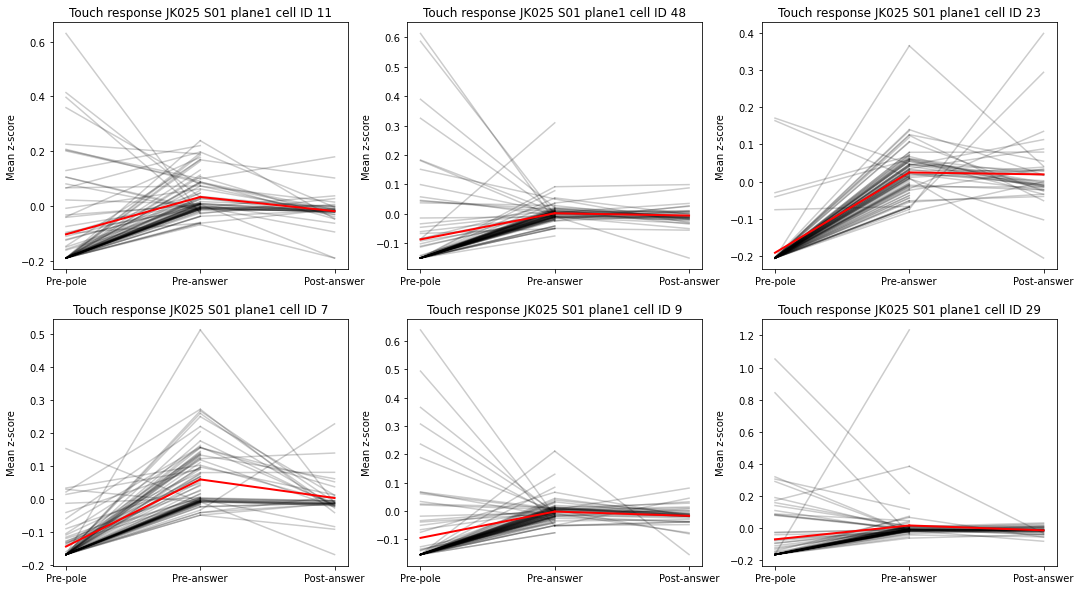

In [ ]:
# Test the p-value by plotting individual cell
p001_pre_answer_ind = np.where(pvalue_pre_answer_response<0.001)[0]
print(len(p001_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p001_pre_answer_ind)))
rand_inds = np.random.choice(p001_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')


Text(0.5, 1.0, 'JK025 S01 plane1: All cells\nmean=-0.2527 p=2.0847e-36')

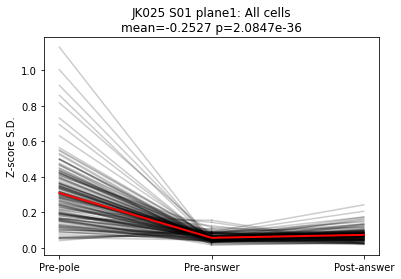

In [ ]:
# Reduced variability?
p_std_change = stats.ttest_1samp(np.nanstd(pre_answer_response, axis=0) - np.nanstd(pre_pole_activity, axis=0), 0).pvalue
mean_std_change = np.mean(np.nanstd(pre_answer_response, axis=0) - np.nanstd(pre_pole_activity, axis=0))
fig, ax = plt.subplots()
pre_answer_std = np.nanstd(pre_answer_response, axis=0)
pre_pole_std = np.nanstd(pre_pole_activity, axis=0)
post_answer_std = np.nanstd(post_answer_response, axis=0)
for ii in range(pre_answer_response.shape[0]):
    ax.plot([1,2], [pre_pole_std[ii], pre_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([1,2], [np.mean(pre_pole_std), np.mean(pre_answer_std)], 'r-', linewidth=2)
for ii in range(pre_answer_response.shape[0]):
    ax.plot([2,3], [pre_answer_std[ii], post_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([2,3], [np.mean(pre_answer_std), np.mean(post_answer_std)], 'r-', linewidth=2)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
ax.set_ylabel('Z-score S.D.')
ax.set_title(f'{session_plane_info}: All cells\nmean={mean_std_change:.4f} p={p_std_change:.4e}')

Text(0.5, 1.0, 'JK025 S01 plane1 Pre-answer - pre-pole; p < 0.001\nmean=-0.0929 p=3.0520e-13')

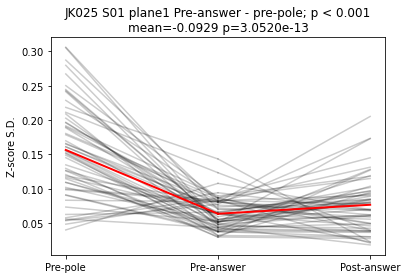

In [ ]:
# What about p<0.001 cells?
p_std_change = stats.ttest_1samp(np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0) - np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0), 0).pvalue
mean_std_change = np.mean(np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0) - np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0))

fig, ax = plt.subplots()
pre_answer_std = np.nanstd(pre_answer_response[:,p001_pre_answer_ind], axis=0)
pre_pole_std = np.nanstd(pre_pole_activity[:,p001_pre_answer_ind], axis=0)
post_answer_std = np.nanstd(post_answer_response[:,p001_pre_answer_ind], axis=0)
for ii in range(len(p001_pre_answer_ind)):
    ax.plot([1,2], [pre_pole_std[ii], pre_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([1,2], [np.mean(pre_pole_std), np.mean(pre_answer_std)], 'r-', linewidth=2)
for ii in range(len(p001_pre_answer_ind)):
    ax.plot([2,3], [pre_answer_std[ii], post_answer_std[ii]], 'k-', alpha=0.2)
ax.plot([2,3], [np.mean(pre_answer_std), np.mean(post_answer_std)], 'r-', linewidth=2)
ax.set_xticks([1,2,3])
ax.set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
ax.set_ylabel('Z-score S.D.')
ax.set_title(f'{session_plane_info} Pre-answer - pre-pole; p < 0.001\nmean={mean_std_change:.4f} p={p_std_change:.4e}')

20
0


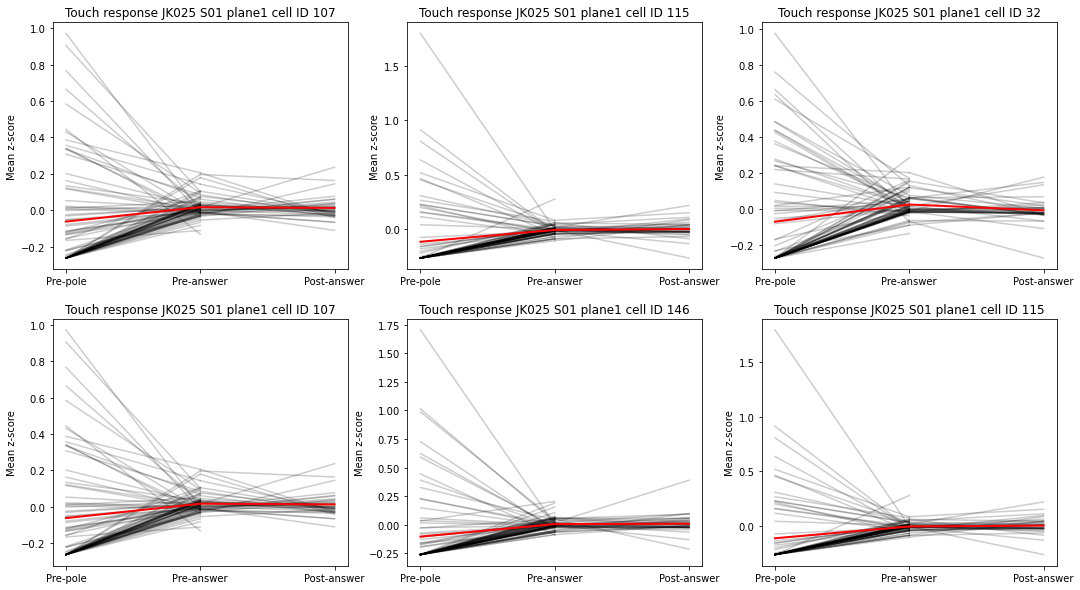

In [ ]:
# 0.001 <= p < 0.01
p01_pre_answer_ind = np.setdiff1d(np.where(pvalue_pre_answer_response<0.01)[0], np.where(pvalue_pre_answer_response<0.001)[0])
print(len(p01_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p01_pre_answer_ind)))
rand_inds = np.random.choice(p01_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')

15
0


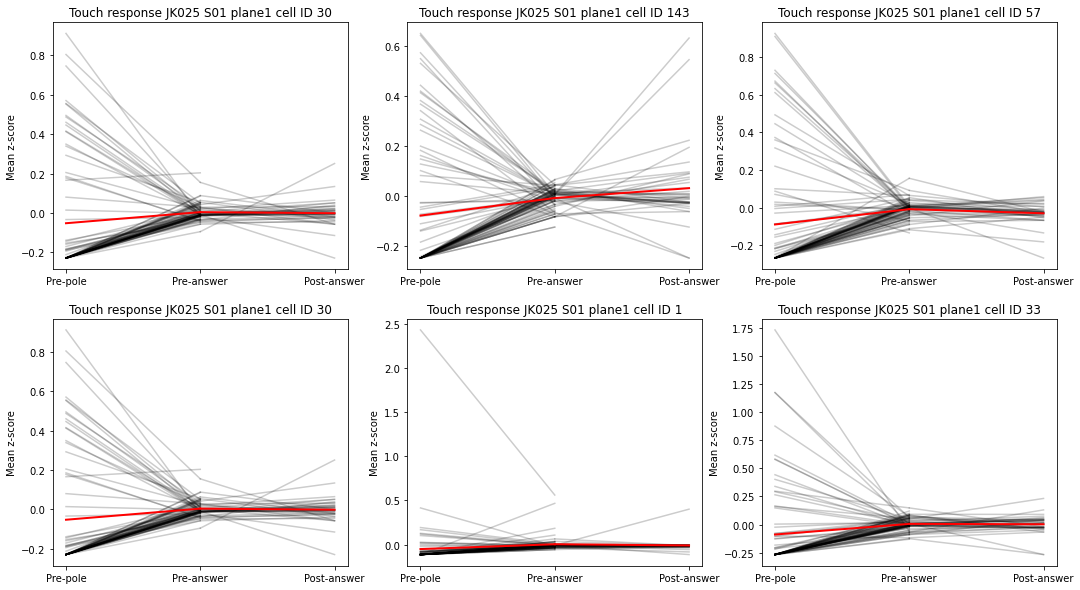

In [ ]:
# 0.01 <= p < 0.05
p05_pre_answer_ind = np.setdiff1d(np.where(pvalue_pre_answer_response<0.05)[0], np.where(pvalue_pre_answer_response<0.01)[0])
print(len(p05_pre_answer_ind))
negative_response_ind = np.where(np.nanmean(pre_answer_response, axis=0) - np.nanmean(pre_pole_activity, axis=0) < 0)[0]
print(len(np.intersect1d(negative_response_ind, p05_pre_answer_ind)))
rand_inds = np.random.choice(p05_pre_answer_ind,6)
fig, ax = plt.subplots(2,3,figsize=(18,10))
for i, ind in enumerate(rand_inds):
    iy = i // 3
    ix = i % 3
    for ii in range(pre_pole_activity.shape[0]):
        ax[iy,ix].plot([1,2], [pre_pole_activity[ii,ind], pre_answer_response[ii,ind]], 'k-', alpha=0.2)
        ax[iy,ix].plot([2,3], [pre_answer_response[ii,ind], post_answer_response[ii,ind]], 'k-', alpha=0.2)
    ax[iy,ix].plot([1,2], [np.nanmean(pre_pole_activity[:,ind]), np.nanmean(pre_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].plot([2,3], [np.nanmean(pre_answer_response[:,ind]), np.nanmean(post_answer_response[:,ind])], 'r-', linewidth=2, alpha=1)
    ax[iy,ix].set_xticks([1,2,3])
    ax[iy,ix].set_xticklabels(['Pre-pole', 'Pre-answer', 'Post-answer'])
    ax[iy,ix].set_ylabel('Mean z-score')
    ax[iy,ix].set_title(f'Touch response {session_plane_info} cell ID {ind}')